In [181]:
import json
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from datetime import datetime
from empyrical.utils import nanmean, nanstd
from datetime import timedelta
import numpy as np
import yfinance as yf
import pandas as pd
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import pandas_datareader.data as web
from datetime import timedelta
import plotly.express as px
from sklearn.preprocessing import StandardScaler
from sklearn_som.som import SOM



In [182]:
file = '/Users/hannes/Downloads/540136b93e7be9e7b2edabcebb808dd8.json'
with open(file) as f:  
    data = json.load(f)

In [183]:
x_items = []
y_items = []
for item in data['Charts']['Strategy Equity']['Series']['Equity']['Values']:
    x_items.append(item['x'])
    y_items.append(item['y'])

x_items_b = []
y_items_b = []
for item in data['Charts']['Benchmark']['Series']['Benchmark']['Values']:
    x_items_b.append(item['x'])
    y_items_b.append(item['y'])

x_items = [datetime.fromtimestamp(x) for x in x_items]
x_items_b = [datetime.fromtimestamp(x) for x in x_items_b]

In [184]:
strat_df = pd.DataFrame(y_items, index = x_items, columns = ['Strategy'])
bench_df = pd.DataFrame(y_items_b, index = x_items_b, columns = ['Benchmark'])

# Get first and last dates
strat_rtns = strat_df.pct_change().dropna()
min_date = strat_rtns[strat_rtns['Strategy'] != 0].index.min() - timedelta(days=1)
max_date = strat_rtns.index.max()

# Have same starting point for both
strat_df = strat_df[min_date:]
bench_df = bench_df[min_date:]

# Resample to daily data 
strat_df = strat_df.resample('D').last()
bench_df = bench_df.resample('D').last()

In [185]:
def calc_sharpe(df: pd.DataFrame) -> float:
    '''
    Sharpe Ratio = ( returns(p) - returns(f) )/ standard deviation(p)
    where rf = 0
    '''
    df_temp = df.copy()
    df_temp['rtns'] = df_temp.pct_change()
    sharpe = df_temp['rtns'].mean() / df_temp['rtns'].std()
    return sharpe * np.sqrt(252)

In [186]:
def calc_sortino(df: pd.DataFrame) -> float:
    '''
    Sorting Ratio = ( returns(p) - returns(f) )/ standard deviation(p) of negative returns
    where rf = 0
    '''
    df_temp = df.copy()
    df_temp['rtns'] = df_temp.pct_change()
    sharpe = df_temp['rtns'].mean() / df_temp['rtns'][df_temp['rtns'] <0].std()
    return sharpe * np.sqrt(252)

In [187]:
def max_drawdown(df: pd.DataFrame) -> float:
    rtns = df.pct_change()
    series = rtns.iloc[:,0]
    cum_ret = (series+1).cumprod()
    peak = cum_ret.expanding(min_periods=1).max()
    dd = (cum_ret/peak)-1
    return dd.min()

In [188]:
def compute_regimes(start_date, end_date, k=8):
    print(start_date, end_date)
    nasdaq = web.DataReader('NASDAQCOM', "fred", start_date, end_date).dropna().resample('W').last() 
    nasdaq2= nasdaq.pct_change(periods=4)[1:] # compute weekly returns
    infl=web.DataReader('CPIAUCSL', "fred", start_date, end_date).dropna()
    infl2=infl.pct_change(periods=12)[1:] # inflation wrt prior year
    infl3=infl2.dropna().resample('W').mean().interpolate() # resample to weekly data
    int_rate=web.DataReader('DFF', "fred", start_date, end_date).dropna()
    int_rate2=int_rate.resample('W').mean() # resample to weekly data

    aux=nasdaq2
    aux['INFLATION']=infl3
    aux['INTEREST_R']=int_rate2
    aux=aux.dropna()

    scaler = StandardScaler() # scale data to std normal
    scaler.fit(aux)
    norm_data=pd.DataFrame(scaler.transform(aux),index=aux.index,columns=aux.columns)

    som = SOM(m=k, n=1, dim=norm_data.shape[1]) # Self-Organising Map
    som.fit(norm_data.to_numpy())
    hs = som.predict(norm_data.to_numpy())
    st = pd.DataFrame(hs,index=norm_data.index)
    data = pd.concat([norm_data,st],axis=1,sort='False').dropna()
    data.rename(columns={0:'REGIME'}, inplace=True)
    return data


In [189]:
regimes = compute_regimes(start_date=(min_date - timedelta(days=400)).strftime("%Y-%m-%d"), end_date=max_date.strftime("%Y-%m-%d"))

2015-02-26 2022-10-15


/var/folders/5r/3sxxysys3kb_pxzpp4npjd9h0000gn/T/ipykernel_2253/490563439.py:24: FutureWarning: Passing non boolean values for sort is deprecated and will error in a future version!
  data = pd.concat([norm_data,st],axis=1,sort='False').dropna()


In [200]:
date_df = pd.DataFrame(0,index=pd.date_range(start=min_date, end=max_date).date, columns=['0'])
date_regimes = date_df.join(regimes).backfill()
combined_df = date_regimes.dropna(axis=0).join(strat_df)[['REGIME','Strategy']]
combined_df['Strategy'] = combined_df['Strategy']/combined_df['Strategy'][0]
combined_df['rtns'] = combined_df['Strategy'].pct_change()
combined_df = combined_df.dropna(axis=0, how='any')
combined_df

,REGIME,Strategy,rtns
2016-04-02,4.0,1.000949,0.000949
2016-04-03,4.0,1.000949,0.000000
2016-04-04,4.0,1.000949,0.000000
2016-04-05,4.0,1.000085,-0.000863
2016-04-06,4.0,1.000690,0.000605
...,...,...,...
2022-08-31,0.0,1.575910,-0.009494
2022-09-01,0.0,1.559964,-0.010119
2022-09-02,0.0,1.547668,-0.007882
2022-09-03,0.0,1.531070,-0.010725


In [211]:
import plistlib
from scipy import stats as stats

regime_list = []
ann_rts_list = []
p_list = []

for regime in sorted(combined_df.REGIME.unique()):
    rtns = combined_df[combined_df.REGIME == regime]['rtns']
    mean_rtns = rtns.mean()
    count = rtns.count()
    # print(mean_rtns, count)

    # T_Test
    # H0 : no statistically significant difference between the total returns and returns in individual regimes
    a = combined_df['rtns'].to_numpy()
    b = combined_df[combined_df.REGIME == regime]['rtns'].to_numpy()
    p = stats.ttest_ind(a,b,equal_var=True)[1]
    
    # Annualized returns
    ann_rtns = (1 + mean_rtns)**252 - 1

    # Append to lists to create dataframe
    regime_list.append(f'{regime:.0f}')
    ann_rts_list.append(ann_rtns)
    p_list.append(p)

regime_results = pd.DataFrame({'Regime':regime_list,'Annual_Returns':ann_rts_list,'P_Value':p_list})
regime_results

,Regime,Annual_Returns,P_Value
0,0,-0.045700,0.709924
1,1,-0.500979,0.002703
2,2,0.115056,0.834162
3,3,0.348794,0.545120
4,4,0.339136,0.101458
5,5,0.125930,0.739844
6,6,0.246512,0.366484
7,7,-0.104159,0.261581


In [206]:
a = combined_df['rtns'].to_numpy()
b = combined_df[combined_df['REGIME'] == 1]['rtns'].to_numpy()

In [209]:
stats.ttest_ind(a,b,equal_var=True)[1]

0.0027033379094120475

In [201]:
combined_df

,REGIME,Strategy,rtns
2016-04-02,4.0,1.000949,0.000949
2016-04-03,4.0,1.000949,0.000000
2016-04-04,4.0,1.000949,0.000000
2016-04-05,4.0,1.000085,-0.000863
2016-04-06,4.0,1.000690,0.000605
...,...,...,...
2022-08-31,0.0,1.575910,-0.009494
2022-09-01,0.0,1.559964,-0.010119
2022-09-02,0.0,1.547668,-0.007882
2022-09-03,0.0,1.531070,-0.010725


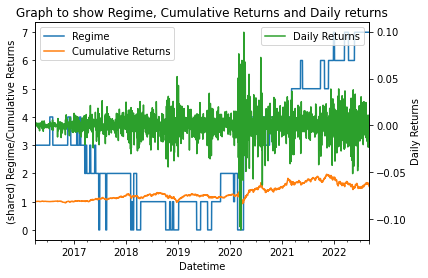

In [178]:
results_df = combined_df.rename(columns={'REGIME':'Regime','Strategy':'Cumulative Returns'})
results_df[['Regime','Cumulative Returns']].plot()
plt.ylabel('(shared) Regime/Cumulative Returns')
plt.xlabel('Datetime')
ax = results_df['rtns'].plot(secondary_y=True, label = 'Daily Returns')
plt.legend(['Daily Returns'])
plt.ylabel('Daily Returns')
plt.title('Graph to show Regime, Cumulative Returns and Daily returns')
plt.show()